## 1. Tạo spark và thực hiện import dữ liệu từ hdfs 

In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [3]:
spark = (
    SparkSession.builder
    .appName("movieDataProcessing")
    .master("spark://spark-master:7077")
    .getOrCreate()
)
print(spark.version)
print(spark.sparkContext.master)

3.2.1
spark://spark-master:7077


In [4]:
spark

In [5]:
keywords = spark.read.csv("hdfs://namenode:9000/input/data/keywords.csv", header=True, inferSchema=True)
ratings = spark.read.csv("hdfs://namenode:9000/input/data/ratings.csv", header=True, inferSchema=True)
links = spark.read.csv("hdfs://namenode:9000/input/data/links.csv", header=True, inferSchema=True)

In [6]:
movies = spark.read.option("header", "True") \
               .option("sep", ",") \
               .option("quote", '"') \
               .option("escape", '"') \
               .option("multiLine", "true") \
               .option("mode", "PERMISSIVE") \
               .csv("hdfs://namenode:9000/input/data/movies_metadata.csv")

In [7]:
 credits = spark.read.option("header", "True") \
               .option("sep", ",") \
               .option("quote", '"') \
               .option("escape", '"') \
               .option("multiLine", "true") \
               .option("mode", "PERMISSIVE") \
               .csv("hdfs://namenode:9000/input/data/credits.csv")

## 2. Data understanding

### 2.1. Tổng quát hóa dữ liệu

Thực hiện tổng quát hóa dữ liệu thông qua việc hiển thị schema, số dòng, số cột của từng dataframe

In [8]:
from pyspark.sql import SparkSession
import pandas as pd

dfs = {
    "Movies": movies,
    "Credits": credits,
    "Keywords": keywords,
    "Links": links,
    "Ratings": ratings
}

for name, df in dfs.items():
    print("=" * 80)
    print(f" Dataset: {name}")
    print("-" * 80)
    
    row_count = df.count()
    col_count = len(df.columns)
    print(f" Rows: {row_count:,} | Columns: {col_count}")
    print("\n Schema:")
    df.printSchema()
    
    print("\n Sample records:")
    sample_pd = df.limit(5).toPandas()
    display(sample_pd)  
    
    print("\n\n")


 Dataset: Movies
--------------------------------------------------------------------------------
 Rows: 45,466 | Columns: 24

 Schema:
root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- titl

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,Toy Story,False,7.7,5415
1,False,None,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",None,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,None,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",None,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173





 Dataset: Credits
--------------------------------------------------------------------------------
 Rows: 45,476 | Columns: 3

 Schema:
root
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)
 |-- id: string (nullable = true)


 Sample records:


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862





 Dataset: Keywords
--------------------------------------------------------------------------------
 Rows: 46,419 | Columns: 2

 Schema:
root
 |-- id: integer (nullable = true)
 |-- keywords: string (nullable = true)


 Sample records:


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"""[{'id': 10090, 'name': 'board game'}, {'id': ..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."





 Dataset: Links
--------------------------------------------------------------------------------
 Rows: 45,843 | Columns: 3

 Schema:
root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)


 Sample records:


,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862





 Dataset: Ratings
--------------------------------------------------------------------------------
 Rows: 26,024,289 | Columns: 4

 Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)


 Sample records:


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


### 2.2. Check Null

Kiểm tra một vài đặc trưng quan trọng xem có null, bằng 0 hay là rỗng hay không

In [9]:
from pyspark.sql import functions as F
movies_stats = movies.select(
    F.count("*").alias("n"),
    F.countDistinct("id").alias("n_distinct_id"),
    F.count(F.when(F.col("id").isNull() | (F.col("id")==""), True)).alias("id_null_or_empty"),
    F.count(F.when(F.col("budget").isin("", "0", None), True)).alias("budget_zero_or_null"),
    F.count(F.when(F.col("revenue").isin("", "0", None), True)).alias("revenue_zero_or_null"),
    F.count(F.when(F.col("runtime").isin("", "0", None), True)).alias("runtime_zero_or_null"),
    F.count(F.when(F.col("release_date").isNull() | (F.col("release_date")==""), True)).alias("release_date_null_or_empty"),
    F.count(F.when(F.col("genres").isNull() | (F.col("genres")==""), True)).alias("genres_null_or_empty")
)
movies_stats.show(truncate=False)


+-----+-------------+----------------+-------------------+--------------------+--------------------+--------------------------+--------------------+
|n    |n_distinct_id|id_null_or_empty|budget_zero_or_null|revenue_zero_or_null|runtime_zero_or_null|release_date_null_or_empty|genres_null_or_empty|
+-----+-------------+----------------+-------------------+--------------------+--------------------+--------------------------+--------------------+
|45466|45436        |0               |36573              |38052               |0                   |87                        |0                   |
+-----+-------------+----------------+-------------------+--------------------+--------------------+--------------------------+--------------------+



### 2.3. Check parse Json

In [10]:
from pyspark.sql import types as T

genre_schema = T.ArrayType(T.StructType([
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True)
]))

cast_schema = T.ArrayType(T.StructType([
    T.StructField("cast_id", T.IntegerType(), True),
    T.StructField("character", T.StringType(), True),
    T.StructField("credit_id", T.StringType(), True),
    T.StructField("gender", T.IntegerType(), True),
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("order", T.IntegerType(), True)
]))

crew_schema = T.ArrayType(T.StructType([
    T.StructField("credit_id", T.StringType(), True),
    T.StructField("department", T.StringType(), True),
    T.StructField("gender", T.IntegerType(), True),
    T.StructField("id", T.IntegerType(), True),
    T.StructField("job", T.StringType(), True),
    T.StructField("name", T.StringType(), True)
]))

keyword_schema = T.ArrayType(T.StructType([
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True)
]))


In [11]:
movies_genre_test = movies.withColumn("genres_parsed", F.from_json("genres", genre_schema))
movies_genre_test.select(
    F.count("*").alias("n"),
    F.sum(F.when(F.col("genres").isNull(),1).otherwise(0)).alias("genres_null"),
    F.sum(F.when((F.col("genres").isNotNull()) & (F.col("genres_parsed").isNull()),1).otherwise(0)).alias("genres_parse_failed")
).show(truncate=False)

credits_test = credits.withColumn("cast_parsed", F.from_json("cast", cast_schema)) \
                      .withColumn("crew_parsed", F.from_json("crew", crew_schema))
credits_test.select(
    F.count("*").alias("n"),
    F.sum(F.when((F.col("cast").isNotNull()) & (F.col("cast_parsed").isNull()),1).otherwise(0)).alias("cast_parse_failed"),
    F.sum(F.when((F.col("crew").isNotNull()) & (F.col("crew_parsed").isNull()),1).otherwise(0)).alias("crew_parse_failed")
).show(truncate=False)

keywords_test = keywords.withColumn("keywords_parsed", F.from_json("keywords", keyword_schema))
keywords_test.select(
    F.count("*").alias("n"),
    F.sum(F.when((F.col("keywords").isNotNull()) & (F.col("keywords_parsed").isNull()),1).otherwise(0)).alias("keywords_parse_failed")
).show(truncate=False)


+-----+-----------+-------------------+
|n    |genres_null|genres_parse_failed|
+-----+-----------+-------------------+
|45466|0          |0                  |
+-----+-----------+-------------------+

+-----+-----------------+-----------------+
|n    |cast_parse_failed|crew_parse_failed|
+-----+-----------------+-----------------+
|45476|31806            |40206            |
+-----+-----------------+-----------------+

+-----+---------------------+
|n    |keywords_parse_failed|
+-----+---------------------+
|46419|631                  |
+-----+---------------------+



Như vậy phải thay đổi cách parse Json string ở phần data cleaning do data (đặc biệt là credits) có một vài điểm đặc biệt dẫn đến việc không parse một cách thông thường được 

### 2.4. Check năm phát hành

In [12]:
from pyspark.sql.functions import to_date, year, lit

movies_date = movies.withColumn("release_date_parsed", to_date("release_date", "yyyy-MM-dd")) \
                    .withColumn("release_year", year("release_date_parsed"))

movies_date.select(
    F.count("*").alias("n"),
    F.sum(F.when(F.col("release_date_parsed").isNull(),1).otherwise(0)).alias("release_date_null"),
    F.sum(F.when(F.col("release_year") < 1895,1).otherwise(0)).alias("year_before_1895"),
    F.sum(F.when(F.col("release_year") > 2025,1).otherwise(0)).alias("year_after_2025")
).show(truncate=False)

year_dist = movies_date.groupBy("release_year").count().orderBy("release_year")
year_dist.show(60, truncate=False) 


+-----+-----------------+----------------+---------------+
|n    |release_date_null|year_before_1895|year_after_2025|
+-----+-----------------+----------------+---------------+
|45466|90               |34              |0              |
+-----+-----------------+----------------+---------------+

+------------+-----+
|release_year|count|
+------------+-----+
|null        |90   |
|1874        |1    |
|1878        |1    |
|1883        |1    |
|1887        |1    |
|1888        |2    |
|1890        |5    |
|1891        |6    |
|1892        |3    |
|1893        |1    |
|1894        |13   |
|1895        |7    |
|1896        |14   |
|1897        |8    |
|1898        |13   |
|1899        |5    |
|1900        |14   |
|1901        |10   |
|1902        |2    |
|1903        |18   |
|1904        |8    |
|1905        |5    |
|1906        |7    |
|1907        |7    |
|1908        |6    |
|1909        |10   |
|1910        |7    |
|1911        |6    |
|1912        |14   |
|1913        |13   |
|1914      

Số lượng năm phát hành Null không quá lớn có thể chấp nhận được

### 2.5. Phân phối dữ liệu số

In [13]:
def clean_num_expr(col):
    return F.when(F.col(col).rlike("^[0-9]+$"), F.col(col).cast("long")) \
            .when(F.col(col).rlike("^[0-9,]+$"), F.regexp_replace(F.col(col), ",", "").cast("long")) \
            .otherwise(None)

movies_num = movies.withColumn("budget_l", clean_num_expr("budget")) \
                   .withColumn("revenue_l", clean_num_expr("revenue")) \
                   .withColumn("vote_count_l", clean_num_expr("vote_count"))

cols = ["budget_l", "revenue_l", "vote_count_l"]
for c in cols:
    non_null_count = movies_num.filter(F.col(c).isNotNull()).count()
    print(f"col={c}, non-null count={non_null_count}")
    if non_null_count > 0:
        q = movies_num.approxQuantile(c, [0.0,0.25,0.5,0.75,0.9,0.99,1.0], 0.01)
        print(c, "quantiles:", q)


col=budget_l, non-null count=45463
budget_l quantiles: [0.0, 0.0, 0.0, 0.0, 6000000.0, 380000000.0, 380000000.0]
col=revenue_l, non-null count=45460
revenue_l quantiles: [0.0, 0.0, 0.0, 0.0, 5450815.0, 2787965087.0, 2787965087.0]
col=vote_count_l, non-null count=45460
vote_count_l quantiles: [0.0, 3.0, 10.0, 33.0, 139.0, 14075.0, 14075.0]


Dữ liệu tài chính như budget hay revenue có chất lượng khá kém (có quá nhiều số 0) và dữ liệu bị lệch khá nặng. Lý do có thể là do thông tin metadata (trong đó có budget và revenue) được lấy từ TMDB (The Movie Database). Đây là một nền tảng mở giống như Wikipedia, nơi dữ liệu do người dùng tự đóng góp.Thường người dùng chỉ quan tâm đến đạo diễn, diễn viên,.. mà bỏ qua những dữ liệu tài chính khô khan.


### 2.6. Kiểm tra tính toàn vẹn của dữ liệu

Thử xem việc join dataframe lại với nhau có ổn không 

In [14]:
links_tmdb = links.select(F.col("movieId").cast("long").alias("movieId"),
                          F.col("tmdbId").cast("string").alias("tmdbId"),
                          F.col("imdbId").alias("imdbId"))

movies_ids = movies.select(F.col("id").alias("tmdbId"))

movies_total = movies_ids.count()
movies_with_link = movies_ids.join(links_tmdb.select("tmdbId").distinct(), "tmdbId", "inner").count()
print(f"movies_total={movies_total}, movies_with_link={movies_with_link}, pct={movies_with_link/movies_total:.2%}")

rating_movieIds_distinct = ratings.select(F.col("movieId").cast("long").alias("movieId")).distinct()
links_movieIds_distinct = links.select(F.col("movieId").cast("long").alias("movieId")).distinct()

orphan_rating_movieIds = rating_movieIds_distinct.join(links_movieIds_distinct, "movieId", "left_anti")
orphan_count = orphan_rating_movieIds.count()
rating_movieIds_total = rating_movieIds_distinct.count()
print(f"rating_movieId distinct total={rating_movieIds_total}, orphan (no link)={orphan_count}, pct={orphan_count/rating_movieIds_total:.2%}")

if orphan_count > 0:
    orphan_top = ratings.join(orphan_rating_movieIds, ratings.movieId == orphan_rating_movieIds.movieId, "inner")\
                        .groupBy(ratings.movieId).agg(F.count("*").alias("n_ratings"))\
                        .orderBy(F.desc("n_ratings")).limit(20)
    orphan_top.show(truncate=False)


movies_total=45466, movies_with_link=45463, pct=99.99%
rating_movieId distinct total=45115, orphan (no link)=0, pct=0.00%


Rating sạch tuyệt đối (100%): Không có bất kỳ lượt đánh giá nào trỏ đến phim "ma" (không tồn tại)
Metadata khớp gần như hoàn hảo (99.9%): Chỉ có 3 phim bị thiếu ID trong tổng số hơn 45.000 phim

## 3. Data cleaning 

### 3.1. Chuyển kiểu dữ liệu

Thực hiện chuyển kiểu dữ liệu cho một số thuộc tính để tính toán

In [15]:
from pyspark.sql import functions as F
df_movies = (movies
    .withColumn("tmdb_id", F.col("id").cast("int"))  
    .withColumn("vote_average", F.col("vote_average").cast("double"))
    .withColumn("vote_count", F.col("vote_count").cast("int"))
    .withColumn("popularity", F.col("popularity").cast("double"))
    .withColumn("runtime", F.col("runtime").cast("double"))
    .withColumn("release_date", F.to_date("release_date"))
)

df_credits = (credits
    .withColumn("tmdb_id", F.col("id").cast("int"))
)

df_keywords = (keywords
    .withColumn("tmdb_id", F.col("id").cast("int"))
)

df_links = (links
    .withColumn("movieId", F.col("movieId").cast("int"))
    .withColumn("imdbId",  F.col("imdbId").cast("int"))
    .withColumn("tmdbId",  F.col("tmdbId").cast("int"))
)

df_ratings = (ratings
    .withColumn("userId", F.col("userId").cast("int"))
    .withColumn("movieId", F.col("movieId").cast("int"))
    .withColumn("rating", F.col("rating").cast("double"))
    .withColumn("timestamp", F.col("timestamp").cast("long"))
)

In [16]:
df_movies_clean = (
    df_movies
    .withColumn("budget", F.when(F.col("budget").cast("double") == 0, None)
                            .otherwise(F.col("budget").cast("double")))
    .withColumn("revenue", F.when(F.col("revenue").cast("double") == 0, None)
                             .otherwise(F.col("revenue").cast("double")))
    .withColumn("runtime", F.when(F.col("runtime").isNull() | (F.col("runtime") == 0), None)
                             .otherwise(F.col("runtime")))
)


In [17]:
df_movies_clean = (
    df_movies_clean
    .withColumn("adult", F.when(F.col("adult") == "True", True)
                           .when(F.col("adult") == "False", False)
                           .otherwise(None))
    .withColumn("video", F.when(F.col("video") == "True", True)
                           .when(F.col("video") == "False", False)
                           .otherwise(None))
    .withColumn("release_year", F.year("release_date"))
)


### 3.2. Parse Json

Parse JSON trong một số thuộc tính để lấy dữ liệu quan trọng

In [18]:
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import from_json

list_schema = ArrayType(StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True)
]))
cast_schema = ArrayType(StructType([
    StructField("cast_id", IntegerType(), True),
    StructField("character", StringType(), True),
    StructField("credit_id", StringType(), True),
    StructField("gender", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("order", IntegerType(), True),
    StructField("profile_path", StringType(), True),
]))

crew_schema = ArrayType(StructType([
    StructField("credit_id", StringType(), True),
    StructField("department", StringType(), True),
    StructField("gender", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("name", StringType(), True),
    StructField("profile_path", StringType(), True),
]))

df_movies_clean = df_movies_clean.withColumn("genres_parsed", from_json("genres", list_schema))
df_keywords_clean = df_keywords.withColumn("keywords_parsed", from_json("keywords", list_schema))


Do có một số dòng trong cột cast và crew có cấu trúc khác nhau nên không thể parse một cách bình thường do đó phải định nghĩa một hàm mới

In [19]:
def fix_pseudo_json(col):
    c = F.regexp_replace(col, r"'", "§APOS§")
    
    c = F.regexp_replace(c, r"\bNone\b", "null")
    c = F.regexp_replace(c, r"\bTrue\b", "true")
    c = F.regexp_replace(c, r"\bFalse\b", "false")
    
    c = F.regexp_replace(c, r'§APOS§§APOS§([^§]+?)§APOS§§APOS§', r'§APOS§$1§APOS§') 
    

    c = F.regexp_replace(c, r'([\[{,:])\s*§APOS§', r'$1"') 
    c = F.regexp_replace(c, r'§APOS§\s*([\]},:)])', r'"$1') 
    
    c = F.regexp_replace(c, r"§APOS§", "'")
    
    return c
df_credits_fixed = (df_credits
    .withColumn("cast_json", fix_pseudo_json(F.col("cast")))
    .withColumn("crew_json", fix_pseudo_json(F.col("crew")))
    .withColumn("cast_parsed", F.from_json("cast_json", cast_schema))
    .withColumn("crew_parsed", F.from_json("crew_json", crew_schema))
)


In [20]:
from IPython.display import display
df_credits_pd = df_credits_fixed.toPandas()
display(df_credits_pd.head(15))

,cast,crew,id,tmdb_id,cast_json,crew_json,cast_parsed,crew_parsed
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,862,"[{""cast_id"": 14,""character"":""Woody (voice)"",""c...","[{""credit_id"":""52fe4284c3a36847f8024f49"",""depa...","[(14, Woody (voice), 52fe4284c3a36847f8024f95,...","[(52fe4284c3a36847f8024f49, Directing, 2, 7879..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,8844,"[{""cast_id"": 1,""character"":""Alan Parrish"",""cre...","[{""credit_id"":""52fe44bfc3a36847f80a7cd1"",""depa...","[(1, Alan Parrish, 52fe44bfc3a36847f80a7c73, 2...","[(52fe44bfc3a36847f80a7cd1, Production, 2, 511..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,15602,"[{""cast_id"": 2,""character"":""Max Goldman"",""cred...","[{""credit_id"":""52fe466a9251416c75077a89"",""depa...","[(2, Max Goldman, 52fe466a9251416c75077a8d, 2,...","[(52fe466a9251416c75077a89, Directing, 2, 2650..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,31357,"[{""cast_id"": 1,""character"": ""Savannah 'Vannah'...","[{""credit_id"":""52fe44779251416c91011acb"",""depa...","[(1, Savannah 'Vannah' Jackson, 52fe4477925141...","[(52fe44779251416c91011acb, Directing, 2, 2178..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,11862,"[{""cast_id"": 1,""character"":""George Banks"",""cre...","[{""credit_id"":""52fe44959251416c75039ed7"",""depa...","[(1, George Banks, 52fe44959251416c75039eb9, 2...","[(52fe44959251416c75039ed7, Sound, 2, 37, Orig..."
5,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",949,949,"[{""cast_id"": 25,""character"":""Lt. Vincent Hanna...","[{""credit_id"":""52fe4292c3a36847f802916d"",""depa...","[(25, Lt. Vincent Hanna, 52fe4292c3a36847f8029...","[(52fe4292c3a36847f802916d, Directing, 2, 638,..."
6,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",11860,11860,"[{""cast_id"": 1,""character"":""Linus Larrabee"",""c...","[{""credit_id"":""52fe44959251416c75039da9"",""depa...","[(1, Linus Larrabee, 52fe44959251416c75039d97,...","[(52fe44959251416c75039da9, Directing, 2, 2226..."
7,"[{'cast_id': 2, 'character': 'Tom Sawyer', 'cr...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",45325,45325,"[{""cast_id"": 2,""character"":""Tom Sawyer"",""credi...","[{""credit_id"":""52fe46bdc3a36847f810f797"",""depa...","[(2, Tom Sawyer, 52fe46bdc3a36847f810f771, 2, ...","[(52fe46bdc3a36847f810f797, Writing, 2, 2075, ..."
8,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",9091,9091,"[{""cast_id"": 1,""character"":""Darren Francis Tho...","[{""credit_id"":""52fe44dbc3a36847f80ae0f1"",""depa...","[(1, Darren Francis Thomas McCord, 52fe44dbc3a...","[(52fe44dbc3a36847f80ae0f1, Directing, 2, 3771..."
9,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710,710,"[{""cast_id"": 1,""character"":""James Bond"",""credi...","[{""credit_id"":""52fe426ec3a36847f801e14b"",""depa...","[(1, James Bond, 52fe426ec3a36847f801e10d, 2, ...","[(52fe426ec3a36847f801e14b, Directing, 2, 1070..."


Đã chuyển đổi thành công cột crew, cast từ string sang list để thuận tiện cho việc trích xuất dữ liệu quan trọng để phân tích như đạo diễn , diễn viên...

### 3.3. Loại bỏ dữ liệu trùng lặp

In [21]:
from pyspark.sql.window import Window

window_spec = Window.partitionBy("title", "release_year").orderBy(F.desc("vote_count"))
df_movies_dedup = (
    df_movies_clean
    .withColumn("row_num", F.row_number().over(window_spec))
    .filter("row_num = 1")
    .drop("row_num")
)


### 3.4. xử lý ngoại lai

Do dữ liệu tài chính tưởng đối lệch nên ta tiến hành loại bỏ những phim có ngân sách và doanh thu cao khủng khiếp ra khỏi tập dữ liệu

In [22]:
quantiles = df_movies_dedup.approxQuantile(["budget", "revenue"], [0.99], 0.05)
budget_max, revenue_max = quantiles[0][0], quantiles[1][0]

df_movies_final = (
    df_movies_dedup
    .filter((F.col("budget") <= budget_max) & (F.col("revenue") <= revenue_max))
)


### 3.5. Kiểm tra giá trị null

In [23]:
def quality_report(df):
    total = df.count()
    return (
        df.select([
            (F.count(F.when(F.col(c).isNull(), c)) / total * 100).alias(c)
            for c in df.columns
        ])
    )

print(" % giá trị null sau cleaning:")
report = quality_report(df_movies_final)
report_pd = report.toPandas()
print(report_pd)


 % giá trị null sau cleaning:
   adult  belongs_to_collection  budget  genres   homepage   id  imdb_id  \
0    0.0              77.246512     0.0     0.0  64.390698  0.0      0.0   

   original_language  original_title  overview  ...  spoken_languages  status  \
0                0.0             0.0  0.204651  ...               0.0     0.0   

     tagline  title  video  vote_average  vote_count  tmdb_id  release_year  \
0  13.953488    0.0    0.0           0.0         0.0      0.0           0.0   

   genres_parsed  
0            0.0  

[1 rows x 27 columns]


Dữ liệu thu được sau khi clean

In [24]:
from IPython.display import display
df_movies_pd = df_movies_final.toPandas()
display(df_movies_pd.head(10))


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,tmdb_id,release_year,genres_parsed
0,False,None,852510.0,"[{'id': 18, 'name': 'Drama'}]",None,2009,tt1032846,ro,"4 luni, 3 săptămîni și 2 zile","Gabita is pregnant, abortion is strictly forbi...",...,"[{'iso_639_1': 'ro', 'name': 'Română'}]",Released,At what moment do we begin to live?,"4 Months, 3 Weeks and 2 Days",False,7.4,158,2009,2007,"[(18, Drama)]"
1,False,None,120000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://movies.disney.com/a-bugs-life,9487,tt0120623,en,A Bug's Life,"On behalf of ""oppressed bugs everywhere,"" an i...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,An epic presentation of miniature proportions.,A Bug's Life,False,6.8,2379,9487,1998,"[(12, Adventure), (16, Animation), (35, Comedy..."
2,False,None,6500000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",None,18923,tt0359423,en,A Home at the End of the World,"Three friends form a bond over the year, Johna...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Family can be whatever you want it to be.,A Home at the End of the World,False,6.8,45,18923,2004,"[(10749, Romance), (18, Drama)]"
3,False,None,3900000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",None,874,tt0060665,en,A Man for All Seasons,A Man for All Seasons is the filmed version of...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,...a motion picture for all times!,A Man for All Seasons,False,7.5,90,874,1966,"[(18, Drama), (36, History)]"
4,False,None,14000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",None,12403,tt0971209,en,A Perfect Getaway,"For their honeymoon, newlyweds Cliff and Cydne...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Welcome to paradise. Enter at your own risk.,A Perfect Getaway,False,6.2,355,12403,2009,"[(53, Thriller), (9648, Mystery), (12, Adventu..."
5,False,None,6000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",None,26522,tt0088146,en,A Soldier's Story,"In the towm of Tynen, Louisiana, a black Maste...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"Alone, far from home, and far from justice, he...",A Soldier's Story,False,6.2,54,26522,1984,"[(18, Drama), (9648, Mystery), (10752, War)]"
6,False,None,160000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,31522,tt0055572,fr,Une Femme est une femme,Exotic dancer Angéla attempts to have a child ...,...,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,None,A Woman Is a Woman,False,7.5,63,31522,1961,"[(35, Comedy), (18, Drama), (10749, Romance)]"
7,False,None,4000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://alanpartridge-alphapapa.com,177699,tt0469021,en,Alan Partridge: Alpha Papa,Alan Partridge has had many ups and downs in l...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,12 hostages. 24 hours. 1 Partridge.,Alan Partridge: Alpha Papa,False,6.5,184,177699,2013,"[(35, Comedy)]"
8,False,None,155000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 36, 'nam...",None,1966,tt0346491,en,Alexander,"Alexander, the King of Macedonia, leads his le...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest legend of all was real.,Alexander,False,5.6,957,1966,2004,"[(10752, War), (36, History), (28, Action), (1..."
9,False,None,20000000.0,"[{'id': 18, 'name': 'Drama'}]",http://www.historyx.com/,73,tt0120586,en,American History X,Derek Vineyard is paroled after serving 3 year...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some Legacies Must End.,American History X,False,8.2,3120,73,1998,"[(18, Drama)]"


## 4. Khám phá đặc điểm phim 

### 4.1. Phân bố budget, revenue, runtime

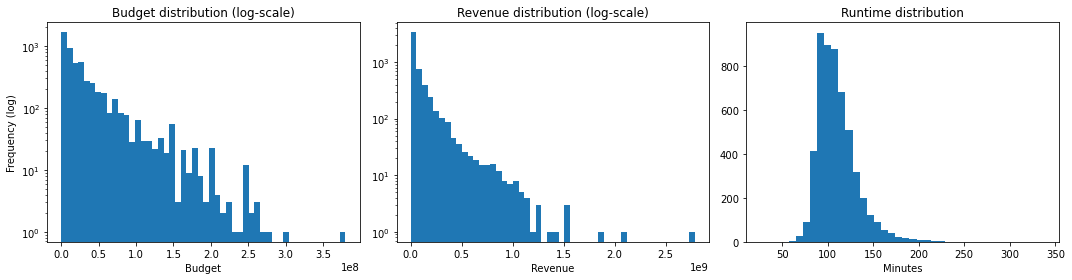

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

sample = df_movies_final.select("budget","revenue","runtime").dropna().toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(sample["budget"], bins=50, log=True)
axes[0].set_title("Budget distribution (log-scale)")
axes[0].set_xlabel("Budget"); axes[0].set_ylabel("Frequency (log)")

axes[1].hist(sample["revenue"], bins=50, log=True)
axes[1].set_title("Revenue distribution (log-scale)")
axes[1].set_xlabel("Revenue")

axes[2].hist(sample["runtime"], bins=40)
axes[2].set_title("Runtime distribution")
axes[2].set_xlabel("Minutes")

plt.tight_layout()
plt.show()


- Phân bố Budget và Revenue hơi lệch về phía trái do nhiều phim kinh phí thấp cùng với đó là không có dữ liệu 
- Runtime có dạng Bell curve đỉnh nằm ở khoảng 90-100 phút

### 4.2. Thể loại phổ biến 

+---------------+-----+
|genre          |count|
+---------------+-----+
|Drama          |2583 |
|Comedy         |1851 |
|Thriller       |1502 |
|Action         |1414 |
|Romance        |1013 |
|Adventure      |957  |
|Crime          |861  |
|Science Fiction|634  |
|Horror         |586  |
|Family         |530  |
+---------------+-----+
only showing top 10 rows



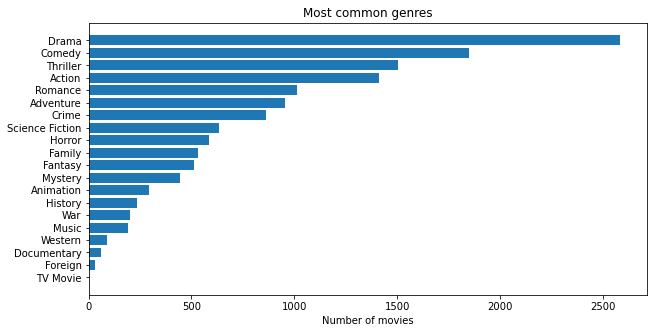

In [26]:
from pyspark.sql import functions as F
genre_count = (
    df_movies_final
    .withColumn("genre", F.explode(F.col("genres_parsed.name"))) 
    .groupBy("genre")
    .count()
    .orderBy(F.desc("count"))
)

genre_count.show(10, truncate=False)



genre_pd = genre_count.toPandas()

plt.figure(figsize=(10,5))
plt.barh(genre_pd["genre"], genre_pd["count"])
plt.title("Most common genres")
plt.xlabel("Number of movies")
plt.gca().invert_yaxis()
plt.show()


### 4.3. Xu hướng phim theo năm 

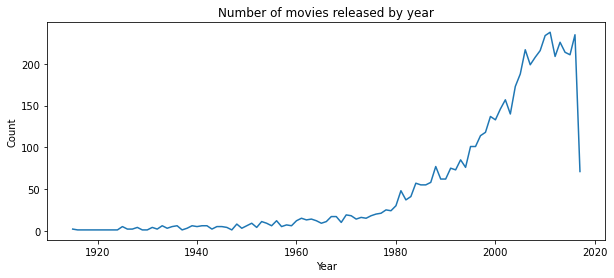

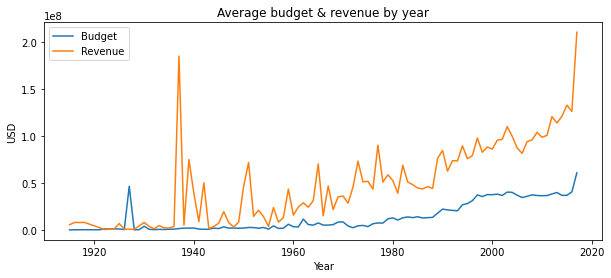

In [27]:
yearly = (df_movies_final
    .groupBy("release_year")
    .agg(F.count("*").alias("num_movies"),
         F.avg("budget").alias("avg_budget"),
         F.avg("revenue").alias("avg_revenue"))
    .orderBy("release_year")
).toPandas()

plt.figure(figsize=(10,4))
plt.plot(yearly["release_year"], yearly["num_movies"])
plt.title("Number of movies released by year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(yearly["release_year"], yearly["avg_budget"], label="Budget")
plt.plot(yearly["release_year"], yearly["avg_revenue"], label="Revenue")
plt.title("Average budget & revenue by year")
plt.xlabel("Year"); plt.ylabel("USD")
plt.legend(); plt.show()


- Số lượng phim đi ngang rất thấp ở những năm 19XX, nhưng bắt đầu từ thập niên 90 và 2000 số lượng phim tăng trưởng nhanh chóng do sự bùng nổ của công nghệ quay phim kỹ thuật số (digital cameras) giúp làm phim rẻ hơn, cộng với sự ra đời của internet giúp phim độc lập (Indie) dễ phát hành hơn.
- Cả Budget và Revenue đều có xu hướng đi lên theo thời gian do các hãng phim ngày càng chi mạnh tay cho các phim "Blockbuster" toàn cầu.

### 4.4. Quốc gia và ngôn ngữ chính 

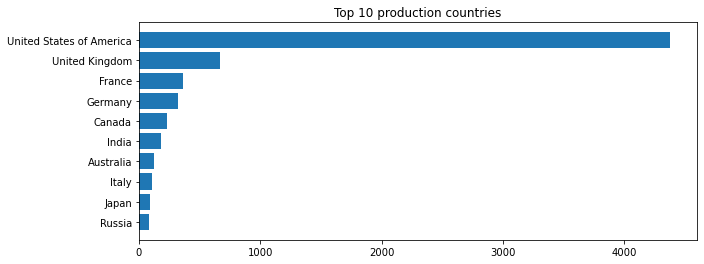

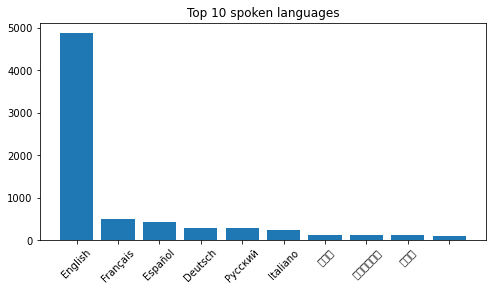

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='IPython.core.pylabtools')
from pyspark.sql.functions import from_json, explode

schema_country = F.schema_of_json('[{"iso_3166_1":"US","name":"United States of America"}]')
schema_lang = F.schema_of_json('[{"iso_639_1":"en","name":"English"}]')

df_countries = (df_movies_final
    .withColumn("production_countries_parsed", from_json("production_countries", ArrayType(StructType([
        StructField("iso_3166_1", StringType()), StructField("name", StringType())
    ]))))
    .withColumn("country", explode("production_countries_parsed"))
    .select(F.col("country.name").alias("country"))
    .groupBy("country").count().orderBy(F.desc("count"))
)

df_langs = (df_movies_final
    .withColumn("spoken_languages_parsed", from_json("spoken_languages", ArrayType(StructType([
        StructField("iso_639_1", StringType()), StructField("name", StringType())
    ]))))
    .withColumn("lang", explode("spoken_languages_parsed"))
    .select(F.col("lang.name").alias("language"))
    .groupBy("language").count().orderBy(F.desc("count"))
)

country_pd = df_countries.limit(10).toPandas()
lang_pd = df_langs.limit(10).toPandas()

plt.figure(figsize=(10,4))
plt.barh(country_pd["country"], country_pd["count"])
plt.title("Top 10 production countries"); plt.gca().invert_yaxis(); plt.show()

plt.figure(figsize=(8,4))
plt.bar(lang_pd["language"], lang_pd["count"])
plt.title("Top 10 spoken languages"); plt.xticks(rotation=45); plt.show()


### 4.5. Phân tích hành vi đánh giá người dùng

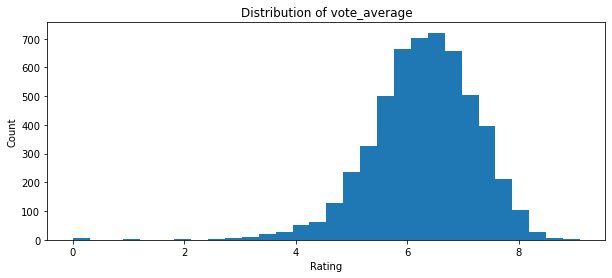

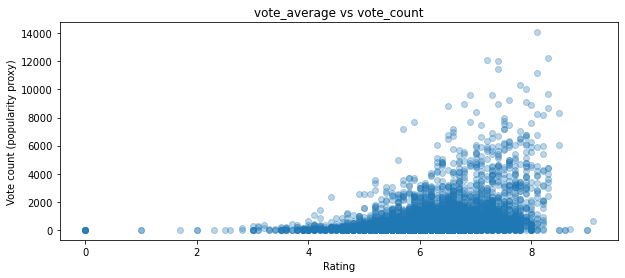

In [29]:
vote_pd = df_movies_final.select("vote_average","vote_count").dropna().toPandas()

plt.figure(figsize=(10,4))
plt.hist(vote_pd["vote_average"], bins=30)
plt.title("Distribution of vote_average")
plt.xlabel("Rating"); plt.ylabel("Count"); plt.show()

plt.figure(figsize=(10,4))
plt.scatter(vote_pd["vote_average"], vote_pd["vote_count"], alpha=0.3)
plt.title("vote_average vs vote_count")
plt.xlabel("Rating"); plt.ylabel("Vote count (popularity proxy)")
plt.show()


- Phân phối điểm số (vote_average) có dạng Bell Curve lệch nhẹ về phía phải, đỉnh nằm ở khoảng từ 6 - 7, đa số phim nằm ở mức "trung bình khá"
- Những phim có nổi tiếng (vote_count > 8000) thường có rating khá cao, do phim dở thì ít ai bỏ thời gian xem và vote

## 4. Phân tích con người trong phim

### 4.1. Trích đạo diễn và diễn viên chính 

In [30]:
# Đạo diễn
df_directors_all = (
    df_credits_fixed
    .withColumn("directors_arr",
        F.expr("transform(filter(crew_parsed, x -> x.job like '%Director%'), x -> x.name)"))
    .select("tmdb_id","directors_arr")
    .filter(F.size("directors_arr") > 0)
)
# Diễn viên chính
df_main_cast = (
    df_credits_fixed
    .withColumn("main_cast",
        F.expr("transform(filter(cast_parsed, x -> x.order <= 3), x -> x.name)"))
    .select("tmdb_id","main_cast")
    .filter(F.size("main_cast") > 0)
)
# Kết hợp với thông tin phim
df_movies_people = df_movies_dedup
df_people = (
    df_movies_people
    .select("tmdb_id","title","release_year","revenue","budget","vote_average")
    .join(df_directors_all, "tmdb_id", "left")
    .join(df_main_cast, "tmdb_id", "left")
    .withColumn("profit", F.col("revenue") - F.col("budget"))
)

### 4.2. Thống kê đạo diễn 

Số phim mỗi đạo diễn

In [31]:
dir_count = (
    df_people
    .withColumn("director", F.explode("directors_arr"))
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"))
    .orderBy(F.desc("num_movies"))
)
dir_count.show(15, truncate=False)

+-------------------+----------+
|director           |num_movies|
+-------------------+----------+
|Charles Lang       |79        |
|John Ford          |68        |
|Harry Stradling Sr.|66        |
|William H. Daniels |65        |
|Michael Curtiz     |65        |
|James Wong Howe    |59        |
|Steven Soderbergh  |55        |
|Douglas Shearer    |55        |
|Werner Herzog      |55        |
|Joseph F. Biroc    |54        |
|Alfred Hitchcock   |53        |
|Lucien Ballard     |52        |
|Sol Polito         |51        |
|Georges Méliès     |51        |
|Victor J. Kemper   |50        |
+-------------------+----------+
only showing top 15 rows



Doanh thu trung bình mỗi đạo diễn (>=3 phim, revenue>0)

In [32]:
dir_rev = (
    df_people
    .withColumn("director", F.explode("directors_arr"))
    .filter(F.col("revenue") > 0)
    .groupBy("director")
    .agg(F.count("*").alias("n"), F.avg("revenue").alias("avg_rev"))
    .filter(F.col("n") >= 3)
    .orderBy(F.desc("avg_rev"))
)
dir_rev.show(15, truncate=False)

+------------------+---+-------------------+
|director          |n  |avg_rev            |
+------------------+---+-------------------+
|Jeremy Hollobon   |4  |1.186132805E9      |
|Todd Cherniawsky  |3  |1.09022692E9       |
|Marc Spicer       |3  |9.646276533333334E8|
|Pierre Coffin     |4  |9.22767554E8       |
|David Yates       |6  |8.89093866E8       |
|Stephen Morahan   |3  |8.62637605E8       |
|Desma Murphy      |4  |8.03695028E8       |
|Richard L. Johnson|5  |7.85285433E8       |
|Lee Unkrich       |4  |7.66872091E8       |
|Kyle Balda        |4  |7.5575038275E8     |
|Neil Lamont       |4  |7.4213594825E8     |
|Patrick Lin       |3  |7.41384116E8       |
|Joss Whedon       |4  |7.4095776775E8     |
|James Cameron     |8  |7.3757628875E8     |
|Pete Docter       |3  |7.185088373333334E8|
+------------------+---+-------------------+
only showing top 15 rows



Rating trung bình mỗi đạo diễn (>=3 phim, vote_average>0)

In [33]:
dir_rating = (
    df_people
    .withColumn("director", F.explode("directors_arr"))
    .filter(F.col("vote_average") > 0)
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"),
         F.avg("vote_average").alias("avg_rating"))
    .filter(F.col("num_movies") >= 3)
    .orderBy(F.desc("avg_rating"))
)
dir_rating.show(10, truncate=False)

+----------------+----------+-----------------+
|director        |num_movies|avg_rating       |
+----------------+----------+-----------------+
|Aaron C. Peer   |4         |9.0              |
|Jonathan Hock   |3         |8.833333333333334|
|Jonas Mekas     |5         |8.680000000000001|
|Tatsuya Oishi   |3         |8.633333333333333|
|Chris Cunningham|3         |8.6              |
|Mikhail Kaufman |3         |8.566666666666668|
|Yoshio Miyajima |3         |8.466666666666667|
|Franco Piavoli  |5         |8.419999999999998|
|Claude Lanzmann |3         |8.366666666666667|
|Raj Kapoor      |3         |8.366666666666667|
+----------------+----------+-----------------+
only showing top 10 rows



### 4.3. Thống kê diễn viên

Số phim mỗi diễn viên

In [34]:
actor_count = (
    df_people
    .withColumn("actor", F.explode("main_cast"))
    .groupBy("actor")
    .count()
    .orderBy(F.desc("count"))
)
actor_count.show(15, truncate=False)

+-----------------+-----+
|actor            |count|
+-----------------+-----+
|John Wayne       |102  |
|Jackie Chan      |94   |
|Michael Caine    |88   |
|Gérard Depardieu |87   |
|Robert De Niro   |87   |
|Christopher Lee  |83   |
|Nicolas Cage     |73   |
|Harvey Keitel    |69   |
|Samuel L. Jackson|69   |
|James Mason      |69   |
|Bruce Willis     |69   |
|Donald Sutherland|69   |
|Bette Davis      |68   |
|Susan Sarandon   |66   |
|Jeff Bridges     |64   |
+-----------------+-----+
only showing top 15 rows



Diễn viên thành công (revenue>1e8 hoặc vote_average>7.5)

In [35]:
successful = (
    df_people
    .withColumn("success_flag",
        (F.col("revenue") > 1e8) | (F.col("vote_average") > 7.5))
    .withColumn("actor", F.explode("main_cast"))
    .filter(F.col("success_flag"))
)

actor_success = (
    successful
    .groupBy("actor")
    .agg(F.count("*").alias("num_success"))
    .orderBy(F.desc("num_success"))
)
actor_success.show(15, truncate=False)

+------------------+-----------+
|actor             |num_success|
+------------------+-----------+
|Robert De Niro    |28         |
|Tom Cruise        |27         |
|Tom Hanks         |26         |
|Brad Pitt         |26         |
|Morgan Freeman    |24         |
|Matt Damon        |23         |
|Samuel L. Jackson |20         |
|Bruce Willis      |20         |
|Denzel Washington |20         |
|Cameron Diaz      |19         |
|Sylvester Stallone|19         |
|Jim Carrey        |19         |
|Harrison Ford     |18         |
|Adam Sandler      |18         |
|Julia Roberts     |18         |
+------------------+-----------+
only showing top 15 rows



### 4.4. Thống kê đạo diễn "chính"

In [36]:
df_directors_all_strict = (
    df_credits_fixed
    .withColumn(
        "directors_arr",
        F.expr("""
            transform(
                filter(
                    crew_parsed,
                    x ->
                        x.department = 'Directing' AND
                        (lower(x.job) = 'director' OR lower(x.job) = 'co-director') AND
                        NOT lower(x.job) rlike 'assistant director' AND
                        NOT lower(x.job) rlike 'second unit'
                ),
                x -> x.name
            )
        """)
    )
    .select("tmdb_id", "directors_arr")
    .filter(F.size("directors_arr") > 0)
)
df_people_strict = (
    df_movies_people
    .select("tmdb_id","title","release_year","revenue","budget","vote_average")
    .join(df_directors_all_strict, "tmdb_id", "left")
)

Số phim mỗi đạo diễn "chính"

In [37]:
dir_count_strict = (
    df_people_strict
    .withColumn("director", F.explode("directors_arr"))
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"))
    .orderBy(F.desc("num_movies"))
)
dir_count_strict.show(15, truncate=False)

+------------------+----------+
|director          |num_movies|
+------------------+----------+
|John Ford         |68        |
|Michael Curtiz    |65        |
|Werner Herzog     |55        |
|Alfred Hitchcock  |53        |
|Georges Méliès    |51        |
|Jean-Luc Godard   |50        |
|Woody Allen       |49        |
|Sidney Lumet      |46        |
|Charlie Chaplin   |44        |
|William A. Wellman|43        |
|Raoul Walsh       |43        |
|Henry Hathaway    |43        |
|Richard Thorpe    |42        |
|Martin Scorsese   |41        |
|George Cukor      |40        |
+------------------+----------+
only showing top 15 rows



 Doanh thu & rating trung bình (>=3 phim)

In [38]:
dir_revenue = (
    df_people_strict
    .withColumn("director", F.explode("directors_arr"))
    .filter(F.col("revenue") > 0)
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"),
         F.avg("revenue").alias("avg_revenue"),
         F.avg("vote_average").alias("avg_rating"))
    .filter(F.col("num_movies") >= 3)
    .orderBy(F.desc("avg_revenue"))
)
dir_revenue.show(10, truncate=False)

+-------------+----------+-------------------+------------------+
|director     |num_movies|avg_revenue        |avg_rating        |
+-------------+----------+-------------------+------------------+
|Pierre Coffin|4         |9.22767554E8       |6.675             |
|David Yates  |6         |8.89093866E8       |7.150000000000001 |
|Kyle Balda   |3         |8.418782206666666E8|6.3               |
|Lee Unkrich  |4         |7.66872091E8       |7.5               |
|Joss Whedon  |4         |7.4095776775E8     |7.4750000000000005|
|James Cameron|8         |7.3757628875E8     |7.312500000000001 |
|Pete Docter  |3         |7.185088373333334E8|7.733333333333334 |
|J.J. Abrams  |5         |7.15843063E8       |7.08              |
|Chris Renaud |4         |6.8464353075E8     |6.574999999999999 |
|Joe Russo    |3         |6.661674783333334E8|6.7               |
+-------------+----------+-------------------+------------------+
only showing top 10 rows



In [39]:
dir_revenue = (
    df_people_strict
    .withColumn("director", F.explode("directors_arr"))
    .filter(F.col("revenue") > 0)
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"),
         F.avg("revenue").alias("avg_revenue"),
         F.avg("vote_average").alias("avg_rating"))
    .filter(F.col("num_movies") >= 3)
    .orderBy(F.desc("avg_revenue"))
)
dir_revenue.show(10, truncate=False)


+-------------+----------+-------------------+------------------+
|director     |num_movies|avg_revenue        |avg_rating        |
+-------------+----------+-------------------+------------------+
|Pierre Coffin|4         |9.22767554E8       |6.675             |
|David Yates  |6         |8.89093866E8       |7.150000000000001 |
|Kyle Balda   |3         |8.418782206666666E8|6.3               |
|Lee Unkrich  |4         |7.66872091E8       |7.5               |
|Joss Whedon  |4         |7.4095776775E8     |7.4750000000000005|
|James Cameron|8         |7.3757628875E8     |7.312500000000001 |
|Pete Docter  |3         |7.185088373333334E8|7.733333333333334 |
|J.J. Abrams  |5         |7.15843063E8       |7.08              |
|Chris Renaud |4         |6.8464353075E8     |6.574999999999999 |
|Joe Russo    |3         |6.661674783333334E8|6.7               |
+-------------+----------+-------------------+------------------+
only showing top 10 rows



đạo diễn được đánh giá cao nhất 

In [40]:
dir_rating = (
    df_people_strict
    .withColumn("director", F.explode("directors_arr"))
    .filter(F.col("vote_average") > 0)
    .groupBy("director")
    .agg(F.count("*").alias("num_movies"),
         F.avg("vote_average").alias("avg_rating"))
    .filter(F.col("num_movies") >= 3)
    .orderBy(F.desc("avg_rating"))
)
dir_rating.show(10, truncate=False)


+------------------+----------+-----------------+
|director          |num_movies|avg_rating       |
+------------------+----------+-----------------+
|Jonathan Hock     |3         |8.833333333333334|
|Jonas Mekas       |5         |8.68             |
|Tatsuya Oishi     |3         |8.633333333333333|
|Chris Cunningham  |3         |8.6              |
|Claude Lanzmann   |3         |8.366666666666667|
|Raj Kapoor        |3         |8.366666666666667|
|Franco Piavoli    |4         |8.35             |
|Lav Diaz          |4         |8.225            |
|Christopher Storer|3         |8.133333333333333|
|Michael Snow      |4         |8.1              |
+------------------+----------+-----------------+
only showing top 10 rows



## 5. Phân tích khán giả và đánh giá

### 5.1. Tổng hợp dữ liệu ratings theo phim 

In [41]:
from pyspark.sql import functions as F

df_rating_stats = (df_ratings
    .groupBy("movieId")
    .agg(
        F.count("*").alias("rating_count"),
        F.avg("rating").alias("rating_mean"),
        F.stddev("rating").alias("rating_std")
    )
)

ln = df_links.select("movieId", "tmdbId").alias("ln")
mv = df_movies_final.select(
        "tmdb_id", "title", "vote_average", "vote_count", "release_year"
     ).alias("mv")
rs = df_rating_stats.alias("rs")

join1 = rs.join(ln, on="movieId", how="left")              
df_ratings_joined = (join1
    .join(mv, F.col("ln.tmdbId") == F.col("mv.tmdb_id"), "left")  
    .drop(F.col("mv.tmdb_id"))                                     
    .withColumnRenamed("tmdbId", "tmdb_id")                      
)

df_ratings_joined.select("movieId","tmdb_id","title","rating_count","rating_mean","vote_average").show(5, truncate=False)


+-------+-------+---------------------+------------+------------------+------------+
|movieId|tmdb_id|title                |rating_count|rating_mean       |vote_average|
+-------+-------+---------------------+------------+------------------+------------+
|7340   |24548  |null                 |339         |2.9587020648967552|null        |
|44022  |950    |Ice Age: The Meltdown|4429        |3.294874689546173 |6.5         |
|1580   |607    |Men in Black         |42193       |3.5733178489322874|6.9         |
|471    |11934  |null                 |12195       |3.654817548175482 |null        |
|2366   |244    |King Kong            |8162        |3.4740872335211956|7.7         |
+-------+-------+---------------------+------------+------------------+------------+
only showing top 5 rows



In [42]:
from pyspark.sql import functions as F

movies_backup = (
    df_movies
    .select(
        F.col("tmdb_id").alias("tmdb_id_bk"),
        F.col("title").alias("title_bk"),
        F.col("vote_average").alias("vote_average_bk"),
        F.col("vote_count").alias("vote_count_bk"),
        F.col("release_date").alias("release_date_bk"),
    )
    .withColumn("release_year_bk", F.year("release_date_bk"))
)

links_clean = df_links.where(F.col("tmdbId").isNotNull())

rs = df_rating_stats.alias("rs")
ln = links_clean.select("movieId","tmdbId").alias("ln")
mv = df_movies_final.select(
        F.col("tmdb_id").alias("tmdb_id_mv"),
        "title","vote_average","vote_count","release_year"
     ).alias("mv")

joined1 = rs.join(ln, on="movieId", how="left")

joined2 = (
    joined1
    .join(mv, F.col("ln.tmdbId") == F.col("mv.tmdb_id_mv"), "left")
    .join(movies_backup, F.col("ln.tmdbId") == F.col("tmdb_id_bk"), "left")
)

df_ratings_joined = (
    joined2
    .withColumn("tmdb_id", F.col("ln.tmdbId"))
    .withColumn("title",        F.coalesce(F.col("mv.title"),        F.col("title_bk")))
    .withColumn("vote_average", F.coalesce(F.col("mv.vote_average"), F.col("vote_average_bk")))
    .withColumn("vote_count",   F.coalesce(F.col("mv.vote_count"),   F.col("vote_count_bk")))
    .withColumn("release_year", F.coalesce(F.col("mv.release_year"), F.col("release_year_bk")))
    .withColumn("tmdb_rating_5", F.col("vote_average")/2.0)  # chuẩn hoá TMDB 0–10 -> 0–5
    .select(
        "movieId","tmdb_id","title",
        "rating_count","rating_mean","rating_std",
        "vote_average","vote_count","release_year","tmdb_rating_5"
    )
)

df_ratings_joined.select(
    F.count(F.when(F.col("title").isNull(), 1)).alias("null_title"),
    F.count(F.when(F.col("vote_average").isNull(), 1)).alias("null_vote_avg"),
    F.count(F.when(F.col("release_year").isNull(), 1)).alias("null_release_year")
).show()


+----------+-------------+-----------------+
|null_title|null_vote_avg|null_release_year|
+----------+-------------+-----------------+
|       377|          377|              459|
+----------+-------------+-----------------+



In [43]:
df_ready = df_ratings_joined

### 5.2. Kiểm tra phân bố ratings

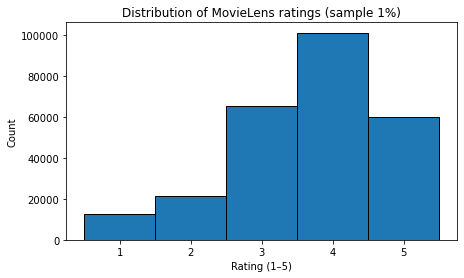

In [44]:
hist_df = df_ratings.select("rating").sample(fraction=0.01).toPandas()
plt.figure(figsize=(7,4))
plt.hist(hist_df["rating"], bins=[0.5,1.5,2.5,3.5,4.5,5.5], edgecolor="black")
plt.xlabel("Rating (1–5)")
plt.ylabel("Count")
plt.title("Distribution of MovieLens ratings (sample 1%)")
plt.show()


In [45]:
df_ready.select("rating_count","rating_mean","rating_std").summary().show()


+-------+------------------+------------------+-------------------+
|summary|      rating_count|       rating_mean|         rating_std|
+-------+------------------+------------------+-------------------+
|  count|             45177|             45177|              37512|
|   mean|  576.262301613653| 3.061347554257258| 0.9587934278286828|
| stddev|3035.3851637841512|0.7310478217034329|0.40044351272366785|
|    min|                 1|               0.5|                0.0|
|    25%|                 2|2.6923076923076925| 0.7637626158259734|
|    50%|                 8|3.1658163265306123| 0.9682458365518541|
|    75%|                69|               3.5| 1.1391308298957796|
|    max|             91921|               5.0|  3.181980515339464|
+-------+------------------+------------------+-------------------+



### 5.3. Top những bộ phim có rating cao nhất

In [46]:
(df_ready
 .filter(df_ready.title.isNotNull())
 .orderBy(df_ready.rating_count.desc())
 .select("title","rating_count","rating_mean")
 .limit(10)
 .show(truncate=False))


+------------------------+------------+------------------+
|title                   |rating_count|rating_mean       |
+------------------------+------------+------------------+
|Forrest Gump            |91921       |4.052925882007376 |
|The Shawshank Redemption|91082       |4.429014514393623 |
|Pulp Fiction            |87901       |4.169975313136369 |
|The Silence of the Lambs|84078       |4.15224553390899  |
|The Matrix              |77960       |4.154098255515649 |
|Star Wars               |77045       |4.132299305600623 |
|Jurassic Park           |74355       |3.6602380472059712|
|Schindler's List        |67662       |4.266530696698294 |
|Braveheart              |66512       |4.016057252826558 |
|Toy Story               |66008       |3.8881574960610834|
+------------------------+------------+------------------+



### 5.4. Top những bộ phim có rating trung bình cao nhất

In [47]:
MIN_VOTES = 1000

(df_ready
 .filter((df_ready.title.isNotNull()) & (df_ready.rating_count >= MIN_VOTES))
 .orderBy(df_ready.rating_mean.desc())
 .select("title","rating_count","rating_mean")
 .limit(10)
 .show(truncate=False))


+-------------------------------+------------+------------------+
|title                          |rating_count|rating_mean       |
+-------------------------------+------------+------------------+
|The Shawshank Redemption       |91082       |4.429014514393623 |
|The Godfather                  |57070       |4.339810758717364 |
|The Usual Suspects             |59271       |4.300188962561792 |
|Schindler's List               |67662       |4.266530696698294 |
|The Godfather: Part II         |36679       |4.263475012950189 |
|Seven Samurai                  |13994       |4.255073602972702 |
|Rear Window                    |21335       |4.232552144363722 |
|12 Angry Men                   |16896       |4.231208570075758 |
|Fight Club                     |60024       |4.2307160469145675|
|One Flew Over the Cuckoo's Nest|40103       |4.22913497743311  |
+-------------------------------+------------+------------------+



### 5.5 Tương quan giữa TMDB vs MovieLens

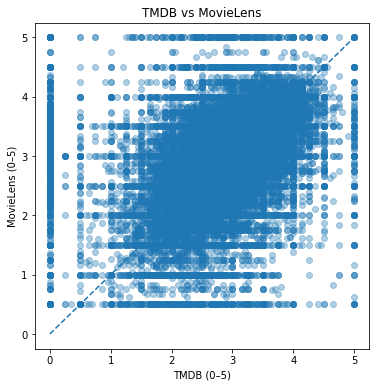

Correlation TMDB vs MovieLens: 0.323


In [48]:
import numpy as np

cmp_pd = (df_ready
          .filter(df_ready.tmdb_rating_5.isNotNull())
          .select("rating_mean","tmdb_rating_5")
          .toPandas())

plt.figure(figsize=(6,6))
plt.scatter(cmp_pd["tmdb_rating_5"], cmp_pd["rating_mean"], alpha=0.35)
plt.plot([0,5],[0,5], linestyle="--")
plt.xlabel("TMDB (0–5)"); plt.ylabel("MovieLens (0–5)")
plt.title("TMDB vs MovieLens")
plt.show()

corr = np.corrcoef(cmp_pd["tmdb_rating_5"], cmp_pd["rating_mean"])[0,1]
print("Correlation TMDB vs MovieLens:", round(float(corr), 3))


### 5.6. Mối quan hệ giữa popularity (số lượt đánh giá) và average rating.

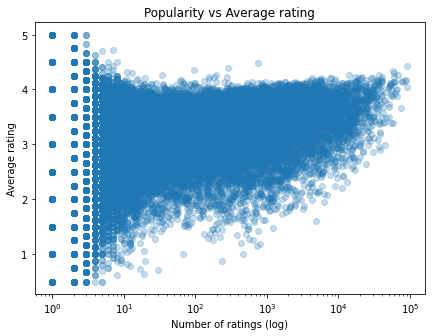

In [49]:
rel_pd = df_ready.select("rating_count","rating_mean").dropna().toPandas()

plt.figure(figsize=(7,5))
plt.scatter(rel_pd["rating_count"], rel_pd["rating_mean"], alpha=0.25)
plt.xscale("log")
plt.xlabel("Number of ratings (log)"); plt.ylabel("Average rating")
plt.title("Popularity vs Average rating")
plt.show()


### 5.7. Xu hướng đánh giá phim theo năm

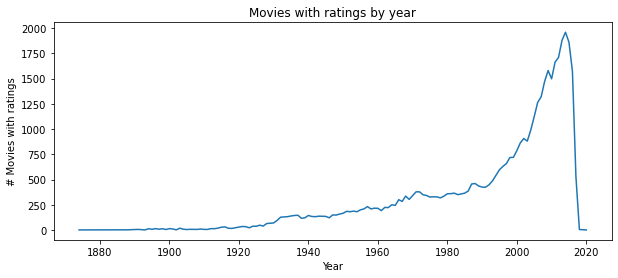

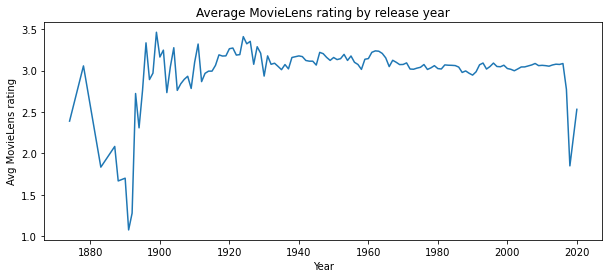

In [50]:
yearly = (df_ready
    .filter(df_ready.release_year.isNotNull())
    .groupBy("release_year")
    .agg(
        F.count("*").alias("num_movies_rated"),
        F.avg("rating_mean").alias("avg_rating_mean")
    )
    .orderBy("release_year")
).toPandas()

plt.figure(figsize=(10,4))
plt.plot(yearly["release_year"], yearly["num_movies_rated"])
plt.xlabel("Year"); plt.ylabel("# Movies with ratings")
plt.title("Movies with ratings by year")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(yearly["release_year"], yearly["avg_rating_mean"])
plt.xlabel("Year"); plt.ylabel("Avg MovieLens rating")
plt.title("Average MovieLens rating by release year")
plt.show()


## 6. Mối quan hệ đa biến 

### 6.1. budget ↔ revenue

kinh tế: budget ↔ revenue, ROI

In [51]:
from pyspark.sql import functions as F

eco = (df_movies_final
    .select("tmdb_id","title","budget","revenue","release_year")
    .where((F.col("budget")>0) & (F.col("revenue")>0))
    .withColumn("roi", F.col("revenue")/F.col("budget"))
    .withColumn("log_budget",  F.log10("budget"))
    .withColumn("log_revenue", F.log10("revenue"))
)

corr = eco.stat.corr("log_budget","log_revenue")
print("corr(log10(budget), log10(revenue)) =", round(float(corr),3))

eco.select(
    F.count("*").alias("n"),
    F.expr("percentile(roi, array(0.5))")[0].alias("roi_median"),
    F.avg("roi").alias("roi_mean")
).show()


corr(log10(budget), log10(revenue)) = 0.702
+----+----------+----------------+
|   n|roi_median|        roi_mean|
+----+----------+----------------+
|5375|  2.057193|5572.10940692508|
+----+----------+----------------+



- Hệ số tương quan khá cao cho thấy ngân sách lớn thường đi kèm với doanh thu lớn
- Median cho thấy hầu hết phim lợi nhuận gấp đôi ngân sách.
- Mean rất lớn vì có một số phim cực kỳ thành công (blockbuster) kéo trung bình lên rất cao → phân bố ROI bị skew cực đoan.

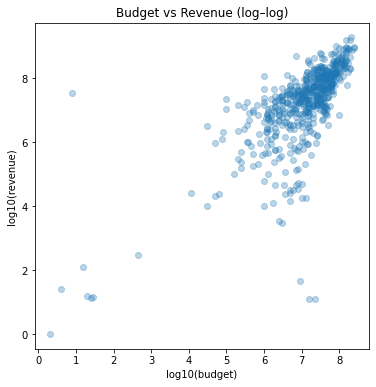

In [52]:
eco_sample = eco.sample(False, 0.1, seed=42).toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(eco_sample["log_budget"], eco_sample["log_revenue"], alpha=0.3)
plt.xlabel("log10(budget)"); plt.ylabel("log10(revenue)")
plt.title("Budget vs Revenue (log–log)")
plt.show()


Nhũng bộ phim có chi phí cao thường có doanh thu cao

### 6.2. genre ↔ rating & genre ↔ ROI

chất lượng & lợi nhuận theo thể loại: genre ↔ rating, genre ↔ ROI

In [53]:
from pyspark.sql import functions as F

df_movies_g = df_movies_final.withColumn(
    "genres_name",
    F.expr("transform(genres_parsed, x -> x.name)")
)

df_movies_g.select("genres_parsed","genres_name").show(3, truncate=False)


+-------------------------------------------------------------------------+-----------------------------------------+
|genres_parsed                                                            |genres_name                              |
+-------------------------------------------------------------------------+-----------------------------------------+
|[{35, Comedy}, {18, Drama}, {10749, Romance}]                            |[Comedy, Drama, Romance]                 |
|[{12, Adventure}, {28, Action}, {18, Drama}, {14, Fantasy}]              |[Adventure, Action, Drama, Fantasy]      |
|[{28, Action}, {80, Crime}, {18, Drama}, {9648, Mystery}, {53, Thriller}]|[Action, Crime, Drama, Mystery, Thriller]|
+-------------------------------------------------------------------------+-----------------------------------------+
only showing top 3 rows



In [54]:
movie_roi = (df_movies_g
    .select("tmdb_id","title","budget","revenue","release_year","genres_name")
    .withColumn("roi",
        F.when((F.col("budget")>0) & (F.col("revenue")>0),
               F.col("revenue")/F.col("budget")))
)


In [55]:
movie_roi_rating = (movie_roi.alias("m")
    .join(df_ready.select("tmdb_id","rating_mean","rating_count").alias("r"),
          on="tmdb_id", how="left")
)


In [56]:
movie_genre = (movie_roi_rating
    .withColumn("genre", F.explode("genres_name"))
    .select("genre","roi","rating_mean","rating_count")
)


In [57]:
MIN_FILMS = 100

genre_stats = (movie_genre
    .groupBy("genre")
    .agg(
        F.count("*").alias("n"),
        F.avg("rating_mean").alias("avg_rating"),
        F.expr("percentile_approx(rating_mean, 0.5)").alias("med_rating"),
        F.avg("roi").alias("avg_roi"),
        F.expr("percentile_approx(roi, 0.5)").alias("med_roi")
    )
    .filter(F.col("n") >= MIN_FILMS)
    .orderBy(F.desc("med_rating"))
)

genre_stats.show(20, truncate=False)


+---------------+----+------------------+------------------+------------------+------------------+
|genre          |n   |avg_rating        |med_rating        |avg_roi           |med_roi           |
+---------------+----+------------------+------------------+------------------+------------------+
|History        |235 |3.5243868441245056|3.569169960474308 |17874.90665178131 |1.79013240625     |
|War            |206 |3.442558649176223 |3.5211267605633805|20380.971566447537|2.041492196421774 |
|Drama          |2595|3.3633505900778   |3.4274322169059013|10079.987290822013|1.7460739130434784|
|Romance        |1019|3.2634155295192855|3.3125            |13197.502538612054|2.1070155         |
|Mystery        |443 |3.256325907652686 |3.294736842105263 |42.3795962966964  |1.750717231638418 |
|Crime          |864 |3.2781008716249516|3.286257124762508 |14352.462506866701|1.87345576        |
|Music          |192 |3.225437583211741 |3.281651997291808 |5.970629180506783 |2.4545454545454546|
|Animation

- Thể loại History, War, Drama được đánh giá cao nhất với median rating ~3.4–3.57.

- Thể loại Music, Animation, Family có median ROI cao nhất (~2.45–2.78), tức phim điển hình sinh lời tốt.

- Horror, Thriller có rating thấp (~2.87–3.19) nhưng vẫn sinh lời khá (median ROI ~1.95–2.48).

- Một số thể loại như History, War có avg ROI rất cao do vài phim cực kỳ thành công kéo trung bình lên.

- Median ROI phản ánh phim điển hình, còn avg ROI dễ bị skew bởi blockbusters.

- Nhìn chung, rating cao không đồng nghĩa với ROI cao; một số phim được đánh giá thấp nhưng vẫn lợi nhuận tốt.

Giới hạn các giá trị ROI cực cao để giảm ảnh hưởng của outlier (do phim bom tấn quá khủng)

In [58]:
p99 = movie_genre.where(F.col("roi").isNotNull()) \
                 .approxQuantile("roi", [0.99], 0.01)[0]

genre_winz = (movie_genre
    .withColumn("roi_w", F.when(F.col("roi") > p99, p99).otherwise(F.col("roi")))
    .groupBy("genre")
    .agg(
        F.count("*").alias("n"),
        F.expr("percentile_approx(rating_mean, 0.5)").alias("med_rating"),
        F.avg("roi_w").alias("avg_roi_w"),
        F.expr("percentile_approx(roi_w, 0.5)").alias("med_roi_w")
    )
    .filter(F.col("n") >= MIN_FILMS)
    .orderBy(F.desc("med_roi_w"))
)

genre_winz.show(15, truncate=False)


+---------------+----+------------------+------------------+------------------+
|genre          |n   |med_rating        |avg_roi_w         |med_roi_w         |
+---------------+----+------------------+------------------+------------------+
|Animation      |295 |3.275             |6.740510310795026 |2.7784161803921568|
|Family         |536 |3.10603371783496  |1905.7731371645716|2.4833333333333334|
|Horror         |586 |2.8693333333333335|1746.9469794713175|2.4808275         |
|Music          |192 |3.281651997291808 |5.970629180506783 |2.4545454545454546|
|Adventure      |966 |3.1797488226059656|1061.209442981026 |2.2896728         |
|Fantasy        |513 |3.1512261580381473|5.948628831331017 |2.1450869         |
|Romance        |1019|3.3125            |13197.502538612054|2.1070155         |
|Comedy         |1854|3.134958011802088 |8355.067226870726 |2.1026119692307694|
|War            |206 |3.5211267605633805|20380.971566447537|2.041492196421774 |
|Action         |1417|3.139130434782609 

- Animation, Family, Horror, Music, Adventure, Fantasy có median ROI cao nhất (~2–2.78) → phim điển hình trong các thể loại này sinh lời ổn định tốt.

- History, War, Crime mặc dù rating cao (median rating ~3.29–3.57) nhưng median ROI ~1.75–1.79 → phim điển hình không sinh lời quá khủng; avg ROI trước đây cao do vài bom tấn cực đoan.

- Romance, Comedy, Action, Thriller, Sci-Fi có median ROI ~2 → sinh lời vừa phải, rating trung bình ~3.13–3.31.
- Kết luận: phim điển hình sinh lời tốt chưa chắc được đánh giá cao, và ngược lại.

### 6.3. Directors ↔ ROI & Actors ↔ ROI

In [59]:
from pyspark.sql import functions as F

# Chuẩn bị main cast
df_main_cast = (
    df_credits_fixed
    .withColumn(
        "main_cast",
        F.expr("transform(filter(cast_parsed, x -> x.order <= 3), x -> x.name)")
    )
    .select("tmdb_id", "main_cast")
    .filter(F.size("main_cast") > 0)
)

# Chuẩn bị directors
df_directors_all_strict = (
    df_credits_fixed
    .withColumn(
        "directors_arr",
        F.expr("""
            transform(
                filter(
                    crew_parsed,
                    x -> x.department = 'Directing' AND
                         (lower(x.job) = 'director' OR lower(x.job) = 'co-director') AND
                         NOT lower(x.job) rlike 'assistant director|second unit|director of photography|art director'
                ),
                x -> x.name
            )
        """)
    )
    .select("tmdb_id", "directors_arr")
    .filter(F.size("directors_arr") > 0)
)

# Kết hợp director và main cast
df_people_strict = (
    df_directors_all_strict
    .join(df_main_cast, on="tmdb_id", how="left")
)

# Tạo dataframe cơ sở (people + ROI)
people_base = (
    df_people_strict
    .select("tmdb_id", "directors_arr", "main_cast")
    .join(movie_roi.select("tmdb_id", "roi"), on="tmdb_id", how="left")
    .where(F.col("roi").isNotNull())
)

MIN_MOVIES_PERSON = 3  # chỉ tính những người có ít nhất 3 phim

# Thống kê ROI theo director
dir_roi = (
    people_base
    .withColumn("director", F.explode("directors_arr"))
    .groupBy("director")
    .agg(
        F.count("*").alias("n"),
        F.avg("roi").alias("avg_roi"),
        F.expr("percentile_approx(roi, 0.5)").alias("med_roi")
    )
    .filter(F.col("n") >= MIN_MOVIES_PERSON)
    .orderBy(F.desc("med_roi"))
)

# Thống kê ROI theo actor
actor_roi = (
    people_base
    .withColumn("actor", F.explode("main_cast"))
    .groupBy("actor")
    .agg(
        F.count("*").alias("n"),
        F.avg("roi").alias("avg_roi"),
        F.expr("percentile_approx(roi, 0.5)").alias("med_roi")
    )
    .filter(F.col("n") >= MIN_MOVIES_PERSON)
    .orderBy(F.desc("med_roi"))
)

# Hiển thị kết quả
dir_roi.show(15, truncate=False)
actor_roi.show(15, truncate=False)


+-------------------+---+------------------+------------------+
|director           |n  |avg_roi           |med_roi           |
+-------------------+---+------------------+------------------+
|David Hand         |3  |157.4987953688264 |124.24256142239135|
|Clyde Geronimi     |5  |73.1762848591954  |53.9700035        |
|Hamilton Luske     |6  |71.05806014469611 |36.54385964912281 |
|James Algar        |3  |116.46325226969594|36.54385964912281 |
|Samuel Armstrong   |3  |116.74142267794717|36.54385964912281 |
|Wilfred Jackson    |5  |68.38514475897071 |36.54385964912281 |
|William Roberts    |3  |116.74142267794717|36.54385964912281 |
|Alex Kendrick      |4  |56.45371766666666 |34.522221         |
|Ben Sharpsteen     |3  |23.645793307317806|32.42307692307692 |
|Henry Joost        |4  |43.93054746491228 |28.5635984        |
|Ariel Schulman     |4  |43.93054746491228 |28.5635984        |
|Terence Young      |4  |32.652040605861245|25.671937818181817|
|Darren Lynn Bousman|3  |22.851406016666

Về đạo diễn:

- Các đạo diễn đứng đầu về med_roi thường là những người làm vài phim nhưng lợi nhuận rất cao, ví dụ David Hand (3 phim, med_roi ≈ 124) hay James Algar / Samuel Armstrong (3 phim, med_roi ≈ 36.5).

- Một số đạo diễn làm nhiều phim (Wolfgang Reitherman, 7 phim) có med_roi thấp hơn, cho thấy làm nhiều phim không đồng nghĩa với ROI cao.

- Trung bình ROI (avg_roi) đôi khi bị ảnh hưởng mạnh bởi một số phim thành công cực đoan, ví dụ James Algar avg_roi ≈ 116, nhưng median thấp hơn (med_roi ≈ 36.5) → cho thấy phân phối ROI bị lệch.

Nhận xét: Đạo diễn làm ít phim nhưng chọn dự án tốt hoặc phim hit có thể đạt ROI cao. Những người làm nhiều phim có ROI trung bình thường thấp hơn vì kết hợp phim thành công và không thành công.

Về diễn viên:

- Một số diễn viên nổi bật về med_roi là những cái tên ít xuất hiện (n ≥ 3), ví dụ Verna Felton med_roi ≈ 90.9, Katie Featherston med_roi ≈ 41.1.

- Một số diễn viên có avg_roi cực kỳ cao nhưng median thấp hơn (Katie Featherston avg_roi ≈ 3254.8 nhưng med_roi ≈ 41.1) → có phim cực thành công kéo trung bình lên rất cao.

- Diễn viên kỳ cựu hoặc tham gia nhiều phim nổi tiếng (Sidney Poitier, Ingrid Bergman) có med_roi thấp hơn, cho thấy họ tham gia nhiều phim với độ biến động ROI khác nhau.

Nhận xét: Diễn viên xuất hiện trong ít phim hit có thể có ROI cao hơn, nhưng trung bình thường bị ảnh hưởng mạnh bởi phim cực kỳ thành công hoặc thất bại. Diễn viên làm nhiều phim nổi tiếng có ROI ổn định hơn nhưng thường thấp hơn top “hitmaker”.